In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import math

In [2]:
# Define data transformations
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL Image to PyTorch Tensor
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the image
])

# Download CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:03<00:00, 56071356.92it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)

Device cuda


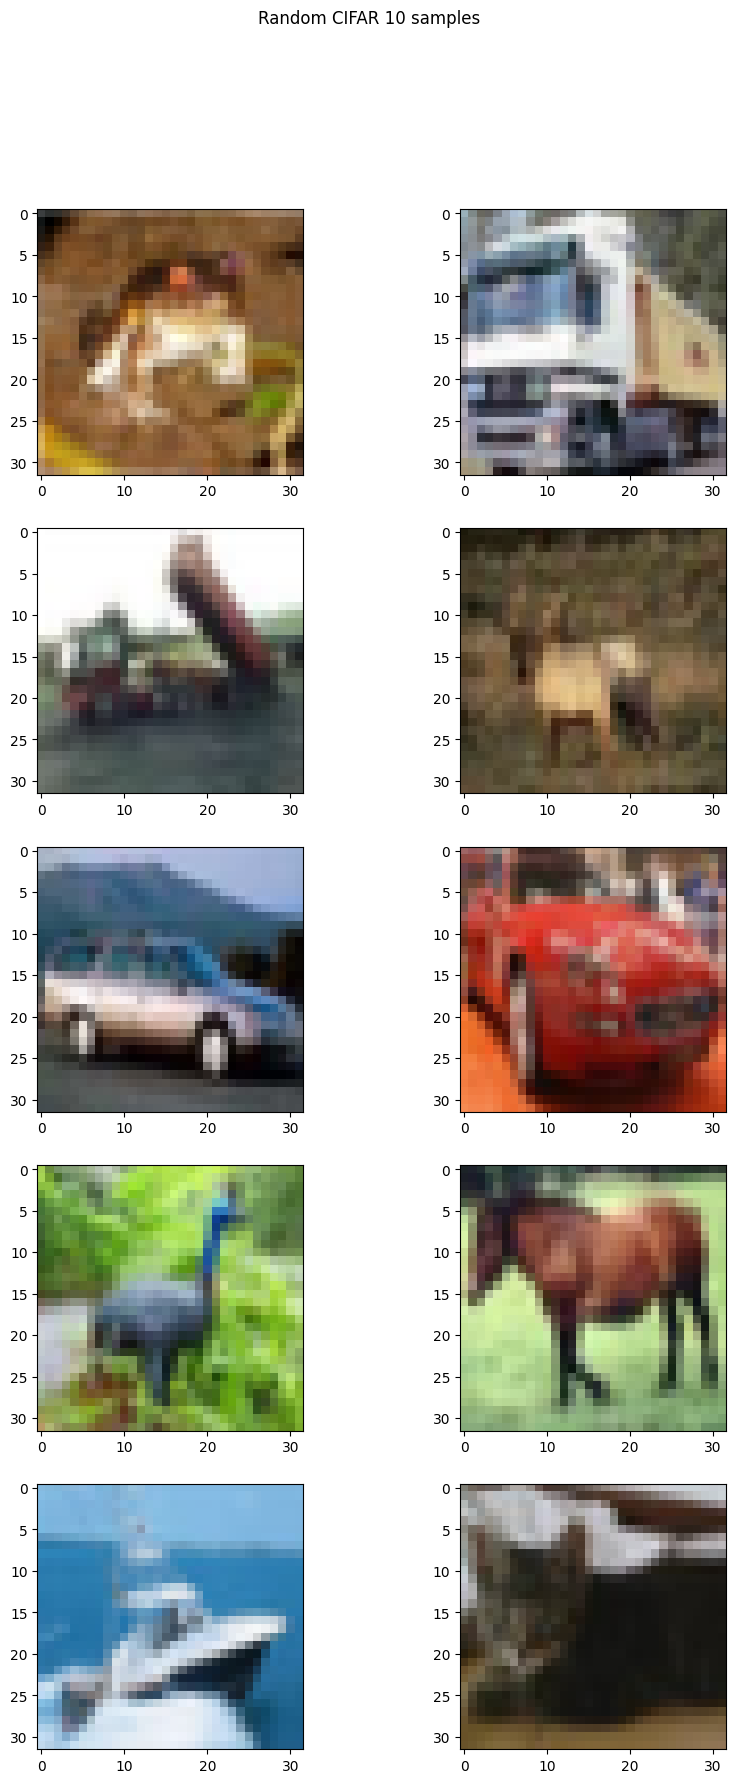

In [6]:
img = 0
fig, axs = plt.subplots(5,2,figsize = (10,20))
for data, labels in train_dataset:
    axs[int(img/2),img%2].imshow(data.permute(1,2,0))
    img += 1
    if(img == 10):
        break
fig.suptitle("Random CIFAR 10 samples")
plt.show()

In [7]:
# Set random seed for reproducibility
torch.manual_seed(42)

# Define the generator network
class Generator(nn.Module):
    def __init__(self, latent_dims = 100):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dims, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

# Define the discriminator network
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


In [22]:
latent_dim = 100
# Build the networks
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)

# Loss function and optimizers
criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002)
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002)

# Training the GAN
epochs = 10
losses_d = []
losses_g = []

for epoch in range(epochs):
    batch = 1
    running_d_loss = 0.0
    running_g_loss = 0.0
    for images, labels in train_loader:
        # Generate real and fake samples
        batch_size = len(images)
        fake_samples = generator(torch.randn(batch_size, latent_dim, 1, 1).to(device))

        # Labels for real and fake samples
        real_labels = torch.ones((batch_size, 1)).to(device)
        fake_labels = torch.zeros((batch_size, 1)).to(device)

        # Train discriminator
        optimizer_D.zero_grad()
        d_loss_real = criterion(discriminator(images.to(device)).view(batch_size,-1), real_labels)
        d_loss_fake = criterion(discriminator(fake_samples.detach()).view(batch_size, -1), fake_labels)
        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        optimizer_D.step()

        # Train generator
        optimizer_G.zero_grad()
        g_loss = criterion(discriminator(fake_samples).view(batch_size,-1), real_labels)
        g_loss.backward()
        optimizer_G.step()

        # Print progress
        print(f"Epoch {epoch}, batch {batch} D Loss: {d_loss.item()}, G Loss: {g_loss.item()}")
        running_d_loss += d_loss.item()
        running_g_loss += g_loss.item()
        batch += 1

    losses_d.append(running_d_loss / len(train_loader))
    losses_g.append(running_g_loss / len(train_loader))



Epoch 0, batch 1 D Loss: 1.521202564239502, G Loss: 1.2098183631896973
Epoch 0, batch 2 D Loss: 2.0567479133605957, G Loss: 0.6319265961647034
Epoch 0, batch 3 D Loss: 2.0965895652770996, G Loss: 0.739459753036499
Epoch 0, batch 4 D Loss: 1.7746620178222656, G Loss: 1.0590054988861084
Epoch 0, batch 5 D Loss: 1.4578665494918823, G Loss: 1.4474859237670898
Epoch 0, batch 6 D Loss: 1.1508536338806152, G Loss: 1.8647606372833252
Epoch 0, batch 7 D Loss: 1.015071153640747, G Loss: 2.1418204307556152
Epoch 0, batch 8 D Loss: 0.849902868270874, G Loss: 2.370532512664795
Epoch 0, batch 9 D Loss: 0.7158071994781494, G Loss: 2.687859058380127
Epoch 0, batch 10 D Loss: 0.6103163361549377, G Loss: 2.9701385498046875
Epoch 0, batch 11 D Loss: 0.586828887462616, G Loss: 2.952526807785034
Epoch 0, batch 12 D Loss: 0.5517715811729431, G Loss: 3.073981761932373
Epoch 0, batch 13 D Loss: 0.4957543611526489, G Loss: 3.2054505348205566
Epoch 0, batch 14 D Loss: 0.4907415211200714, G Loss: 3.2470517158508

Text(0.5, 1.0, 'D loss vs Epoch')

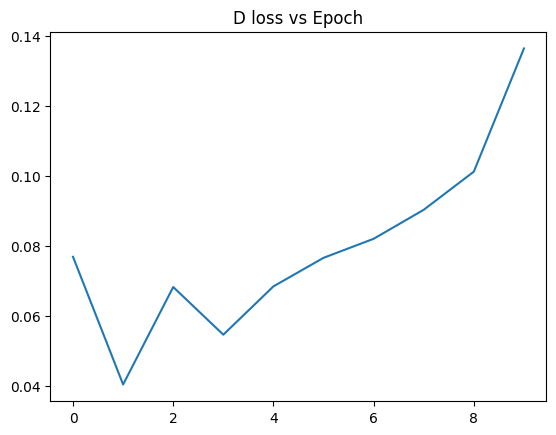

In [26]:
plt.plot(range(10), losses_d)
plt.title("D loss vs Epoch")

Text(0.5, 1.0, 'G loss vs Epoch')

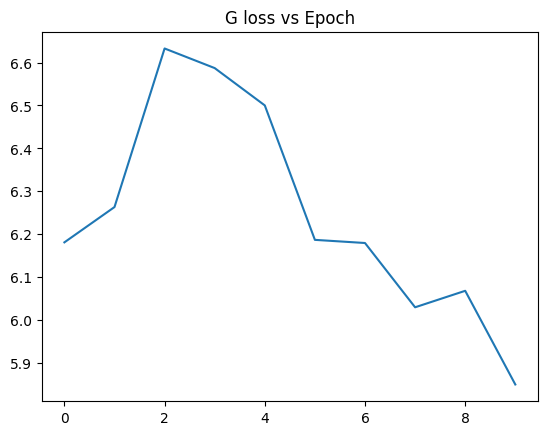

In [27]:
plt.plot(range(10), losses_g)
plt.title("G loss vs Epoch")

In [14]:
samples = generator(torch.randn(10, latent_dim, 1, 1).to(device))

In [15]:
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision.models.inception import inception_v3
from scipy.stats import entropy

def inception_score(imgs, cuda=True, batch_size=1, resize=True, splits=1):
    """Computes the inception score of the generated images imgs

    imgs -- Torch dataset of (3xHxW) numpy images normalized in the range [-1, 1]
    cuda -- whether or not to run on GPU
    batch_size -- batch size for feeding into Inception v3
    splits -- number of splits
    """
    N = len(imgs)

    assert batch_size > 0
    assert N > batch_size

    # Set up dtype
    if cuda:
        dtype = torch.cuda.FloatTensor
    else:
        if torch.cuda.is_available():
            print("WARNING: You have a CUDA device, so you should probably set cuda=True")
        dtype = torch.FloatTensor

    # Set up dataloader
    dataloader = torch.utils.data.DataLoader(imgs, batch_size=batch_size)

    # Load inception model
    inception_model = inception_v3(pretrained=True, transform_input=False).type(dtype)
    inception_model.eval();
    up = nn.Upsample(size=(299, 299), mode='bilinear').type(dtype)
    def get_pred(x):
        if resize:
            x = up(x)
        x = inception_model(x)
        print(x.shape)
        return nn.Softmax(dim = 1)(x).data.cpu().numpy()

    # Get predictions
    preds = np.zeros((N, 1000))

    for i, batch in enumerate(dataloader, 0):
        batch = batch.type(dtype)
        batchv = Variable(batch)
        batch_size_i = batch.size()[0]

        preds[i*batch_size:i*batch_size + batch_size_i] = get_pred(batchv)

    # Now compute the mean kl-div
    split_scores = []

    for k in range(splits):
        part = preds[k * (N // splits): (k+1) * (N // splits), :]
        py = np.mean(part, axis=0)
        scores = []
        for i in range(part.shape[0]):
            pyx = part[i, :]
            scores.append(entropy(pyx, py))
        split_scores.append(np.exp(np.mean(scores)))

    return np.mean(split_scores), np.std(split_scores)

In [16]:
inception_score(samples)

torch.Size([1, 1000])
torch.Size([1, 1000])
torch.Size([1, 1000])
torch.Size([1, 1000])
torch.Size([1, 1000])
torch.Size([1, 1000])
torch.Size([1, 1000])
torch.Size([1, 1000])
torch.Size([1, 1000])
torch.Size([1, 1000])


(2.513082043335968, 0.0)

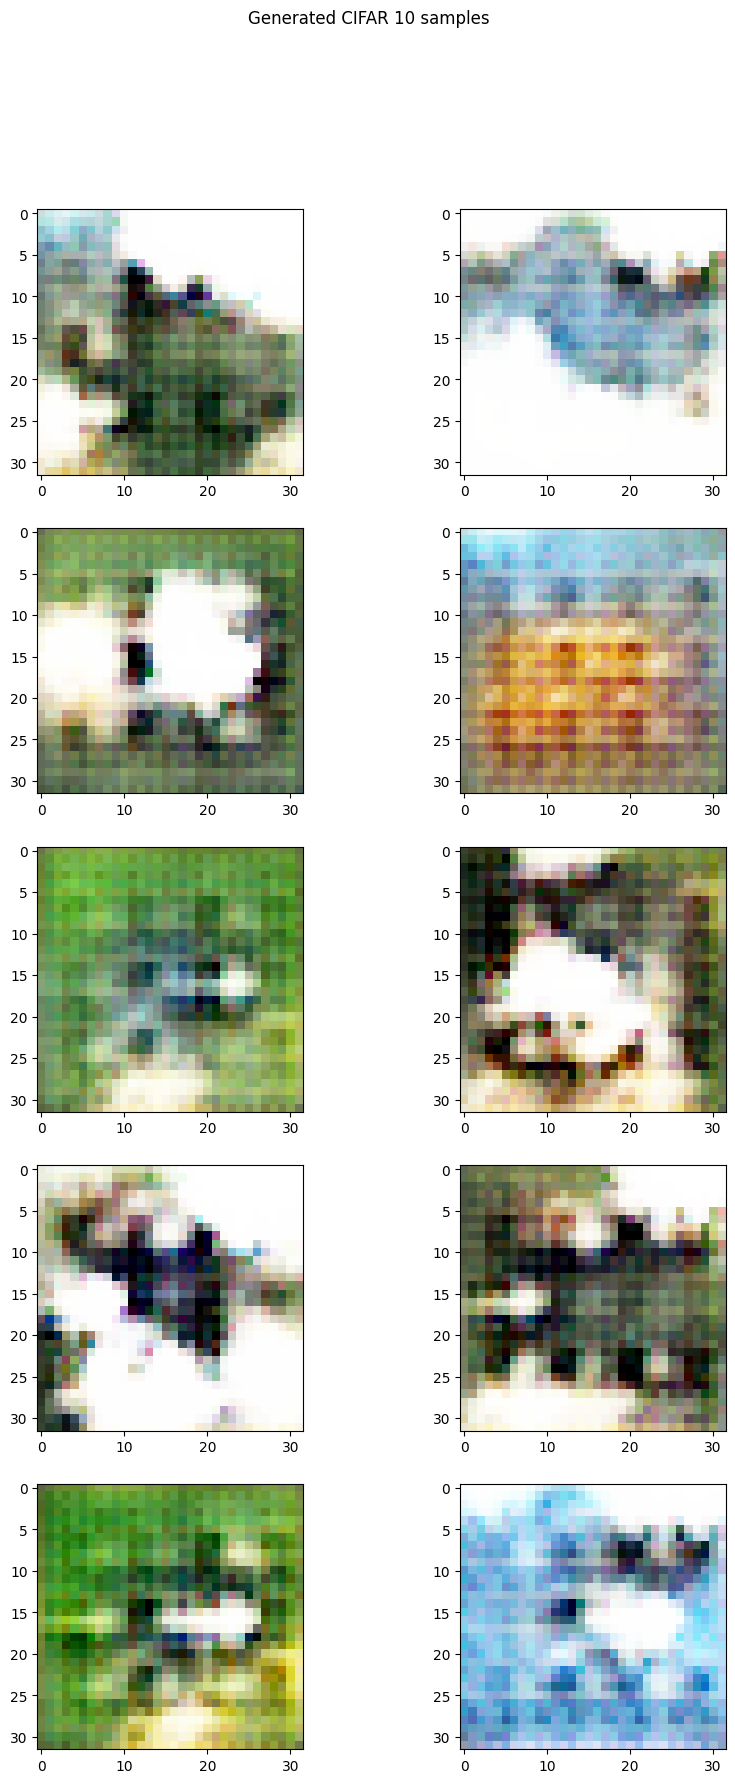

In [21]:
fig, axs = plt.subplots(5,2,figsize = (10,20))
for idx,data in enumerate(samples):
    axs[int(idx/2),idx%2].imshow(data.permute(1,2,0).cpu().detach())
fig.suptitle("Generated CIFAR 10 samples")
plt.show()